<a href="https://colab.research.google.com/github/jagadambika13/gitexercise4/blob/develop/python_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import sqlalchemy as db
from sqlalchemy import create_engine, Table, Column, Integer, Float, MetaData
import numpy as np
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
import unittest
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Load the CSV files
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
ideal_df = pd.read_csv('/content/ideal.csv')


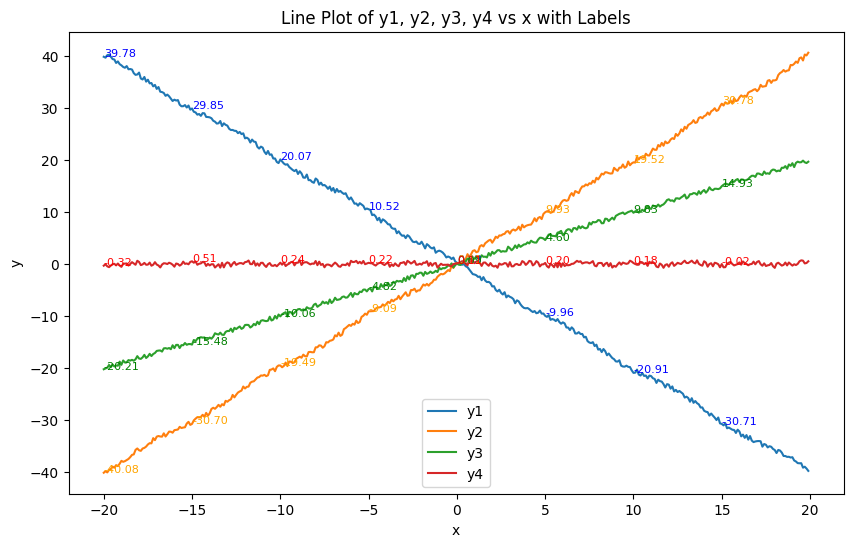

In [ ]:
""" Q1. How do the values of y1, y2, y3, and y4 change with respect to x?"""

# Line Plot with Labels for Question 1
plt.figure(figsize=(10, 6))
plt.plot(train_df['x'], train_df['y1'], label='y1')
plt.plot(train_df['x'], train_df['y2'], label='y2')
plt.plot(train_df['x'], train_df['y3'], label='y3')
plt.plot(train_df['x'], train_df['y4'], label='y4')

# Add labels for specific points
for i in range(0, len(train_df), 50):  # Adjust the step to reduce label density
   plt.text(train_df['x'][i], train_df['y1'][i], f'{train_df["y1"][i]:.2f}', fontsize=8, ha='left', color='blue')
   plt.text(train_df['x'][i], train_df['y2'][i], f'{train_df["y2"][i]:.2f}', fontsize=8, ha='left', color='orange')
   plt.text(train_df['x'][i], train_df['y3'][i], f'{train_df["y3"][i]:.2f}', fontsize=8, ha='left', color='green')
   plt.text(train_df['x'][i], train_df['y4'][i], f'{train_df["y4"][i]:.2f}', fontsize=8, ha='left', color='red')

plt.title('Line Plot of y1, y2, y3, y4 vs x with Labels')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


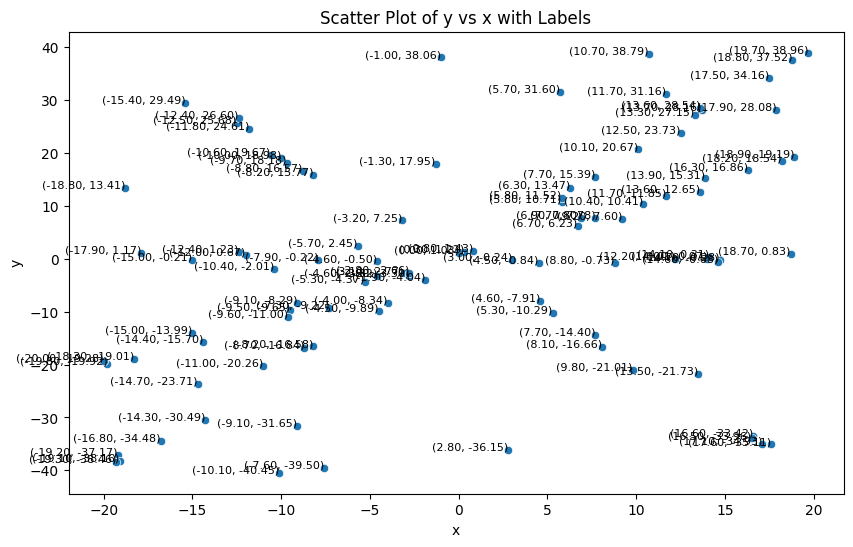

In [ ]:
"""Q2. What is the relationship between x and y?"""

# Scatter Plot with Labels for Question 2
plt.figure(figsize=(10, 6))
sns.scatterplot(x=test_df['x'], y=test_df['y'])

# Add labels for each point
for i in range(len(test_df)):
   plt.text(test_df['x'][i], test_df['y'][i], f'({test_df["x"][i]:.2f}, {test_df["y"][i]:.2f})',
            fontsize=8, ha='right')

plt.title('Scatter Plot of y vs x with Labels')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


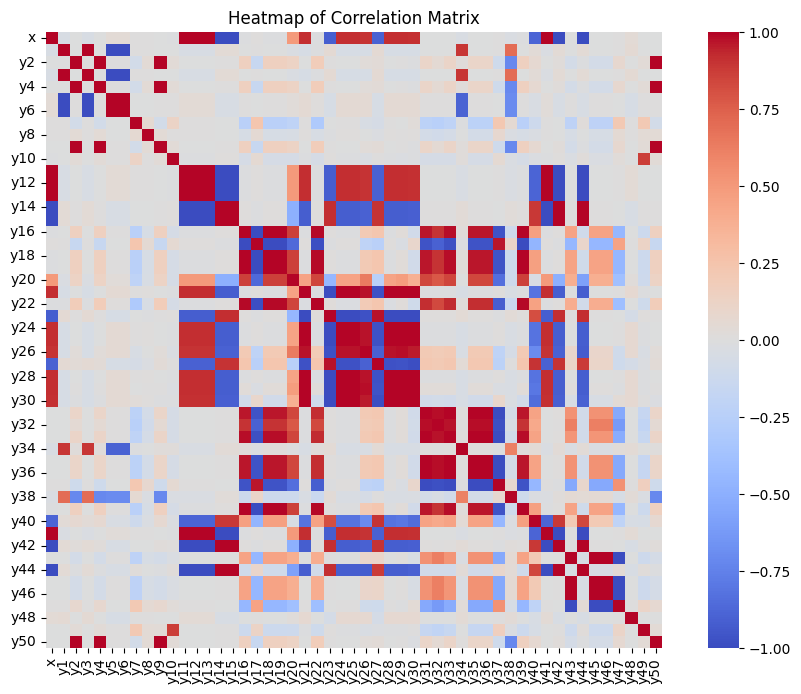

In [ ]:
""" Q3. What is the correlation between the different variables?"""

# Heatmap for Question 3
plt.figure(figsize=(12, 8))
corr_matrix = ideal_df.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', square=True, cbar=True, annot=False, fmt=".2f")
plt.title('Heatmap of Correlation Matrix')
plt.show()


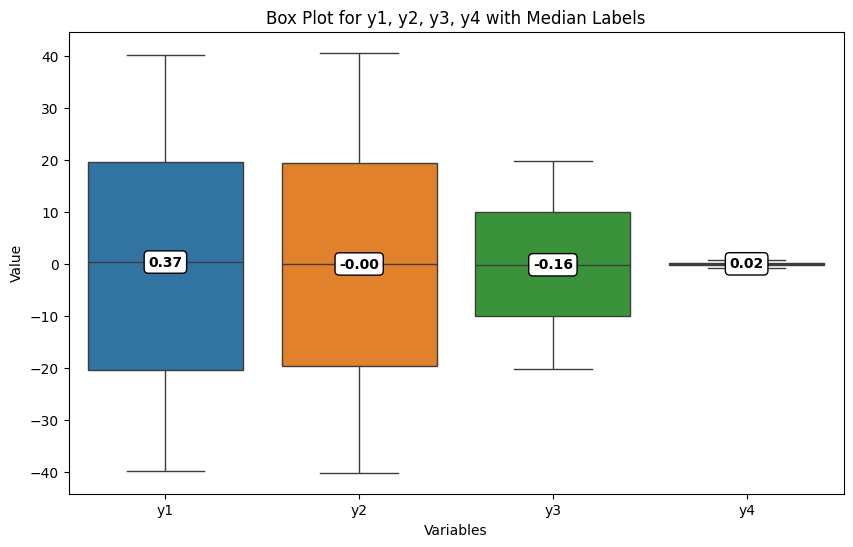

In [ ]:
""" Q4. How do the distributions of y1, y2, y3, and y4 compare?"""

# Box Plot with Labels for Question 4
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df[['y1', 'y2', 'y3', 'y4']])

# Add labels for median values
for i, column in enumerate (train_df[['y1', 'y2', 'y3', 'y4']].columns):
   median_val = train_df[column].median ()
   plt.text(i, median_val, f'{median_val:.2f}', ha='center', va='center',
            fontweight='bold', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.title('Box Plot for y1, y2, y3, y4 with Median Labels')
plt.xlabel('Variables')
plt.ylabel('Value')
plt.show()


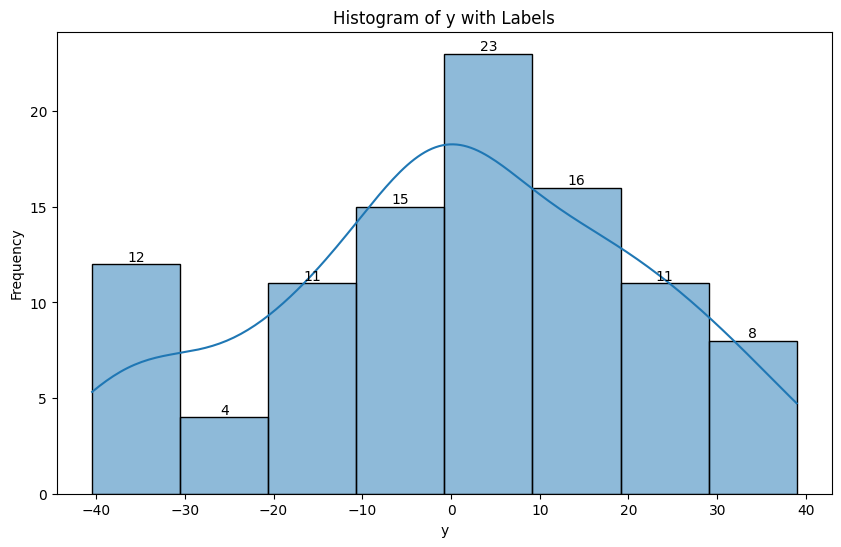

In [ ]:
""" Q5. What is the distribution of y values? """

# Histogram with Labels for Question 5
plt.figure(figsize=(10, 6))
ax = sns.histplot(test_df['y'], kde=True)

# Add labels to the bars
for patch in ax.patches:
   height = patch.get_height()
   plt.text(patch.get_x() + patch.get_width() / 2, height, f'{height:.0f}',
            ha='center', va='bottom', fontsize=10, color='black')

plt.title('Histogram of y with Labels')
plt.xlabel('y')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Step 1: Set up SQLite database
class DatabaseHandler:
   def __init__(self, db_name='ideal_functions.db'):
       self.engine = create_engine(f'sqlite:///{db_name}')
       self.connection = self.engine.connect()
       self.metadata = MetaData()

   def create_tables(self):
       # Creating the training data table
       training_data = Table('training_data', self.metadata,
                             Column('x', Float, primary_key=True),
                             Column('y1', Float),
                             Column('y2', Float),
                             Column('y3', Float),
                             Column('y4', Float)
                             )

       # Creating the ideal functions table
       columns = [Column('x', Float, primary_key=True)]
       for i in range(1, 51):
           columns.append(Column(f'y{i}', Float))
       ideal_functions = Table('ideal_functions', self.metadata, *columns)

       # Creating the test data table
       test_data = Table('test_data', self.metadata,
                         Column('x', Float, primary_key=True),
                         Column('y', Float),
                         Column('Delta_Y', Float),
                         Column('Ideal_Func_No', Integer)
                         )

       # Creating all tables in the database
       self.metadata.create_all(self.engine)

   def load_data(self, csv_file, table_name):
       # Loading CSV data into the database
       df = pd.read_csv(csv_file)
       df.to_sql(table_name, con=self.engine, if_exists='replace', index=False)


# Exception Handling Example
class DataLoadError(Exception):
   """Exception raised for errors in the data loading process."""
   pass

class FunctionFitError(Exception):
   """Exception raised when fitting functions fails."""
   pass


In [ ]:
# Step 2: Implementing Function Fitting with Deviation Check
class FunctionFitter:
   def __init__(self, connection):
       self.connection = connection

   def calculate_least_squares(self, training_table, ideal_table):
       # Query data from training and ideal tables
       training_df = pd.read_sql_table(training_table, self.connection)
       ideal_df = pd.read_sql_table(ideal_table, self.connection)

       selected_functions = {}
       max_deviation = {}

       for i in range(1, 5):  # Loop through the four training functions (y1 to y4)
           min_error = float('inf')
           best_function = None
           max_dev = None

           for j in range(1, 51):  # Loop through the fifty ideal functions
               # Calculate the sum of squared deviations
               squared_deviation = np.sum((training_df[f'y{i}'] - ideal_df[f'y{j}']) ** 2)
               max_deviation_for_function = np.max(np.abs(training_df[f'y{i}'] - ideal_df[f'y{j}']))

               if squared_deviation < min_error:
                   min_error = squared_deviation
                   best_function = j
                   max_dev = max_deviation_for_function

           selected_functions[f'y{i}'] = best_function
           max_deviation[f'y{i}'] = max_dev

           print(f'Best fit for y{i} is y{best_function} with error {min_error} and max deviation {max_dev}')

       return selected_functions, max_deviation


In [ ]:
# Step 3: Mapping Test Data with Deviation Check
class TestMapper:
   def __init__(self, connection):
       self.connection = connection

   def map_test_data(self, test_table, selected_functions, ideal_table, max_deviation):
       test_df = pd.read_sql_table(test_table, self.connection)
       ideal_df = pd.read_sql_table(ideal_table, self.connection)

       mapped_results = []
       for index, row in test_df.iterrows():
           x = row['x']
           y_test = row['y']
           mapped = False

           for key, ideal_func in selected_functions.items():
               y_ideal = ideal_df.loc[ideal_df['x'] == x, f'y{ideal_func}'].values[0]
               delta_y = abs(y_test - y_ideal)

               if delta_y <= max_deviation[key] * np.sqrt(2):
                   mapped_results.append({'x': x, 'y': y_test, 'Delta_Y': delta_y, 'Ideal_Func_No': ideal_func})
                   mapped = True
                   break

           if not mapped:
               mapped_results.append({'x': x, 'y': y_test, 'Delta_Y': None, 'Ideal_Func_No': None})

       mapped_df = pd.DataFrame(mapped_results)
       mapped_df.to_sql('test_data', con=self.connection, if_exists='replace', index=False)


In [ ]:
# Step 4: Best fit
class Visualizer:
   def __init__(self, connection):
       self.connection = connection

   def plot_data(self, selected_functions):
       output_notebook()

       # Load data from database
       training_df = pd.read_sql_table('training_data', self.connection)
       ideal_df = pd.read_sql_table('ideal_functions', self.connection)
       test_df = pd.read_sql_table('test_data', self.connection)

       p = figure(title="Training Data vs Ideal Functions", x_axis_label='x', y_axis_label='y')

       # Plot training data
       colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
       for i in range(1, 5):
           p.line(training_df['x'], training_df[f'y{i}'], legend_label=f'Training y{i}', color=colors[i-1])

       # Plot ideal functions
       for i, func in enumerate(selected_functions.values(), start=1):
           p.line(ideal_df['x'], ideal_df[f'y{func}'], legend_label=f'Ideal y{func}', color=colors[i-1])

       # Plot test data
       p.scatter(test_df['x'], test_df['y'], size=8, legend_label="Test Data", color="red")

       show(p)


# Initialize the database and create tables
db_handler = DatabaseHandler()
db_handler.create_tables()

# Load the CSV data into the corresponding tables
try:
   db_handler.load_data('train.csv', 'training_data')
   db_handler.load_data('ideal.csv', 'ideal_functions')
   db_handler.load_data('test.csv', 'test_data')
except Exception as e:
   raise DataLoadError("Failed to load data") from e

print("Data loaded into the database successfully.")

# Calculate the four best-fit ideal functions
fitter = FunctionFitter(db_handler.connection)
selected_functions, max_deviation = fitter.calculate_least_squares('training_data', 'ideal_functions')

# Map test data to the selected ideal functions and store results in the database
mapper = TestMapper(db_handler.connection)
mapper.map_test_data('test_data', selected_functions, 'ideal_functions', max_deviation)

print("Test data mapped to ideal functions successfully.")

# Visualize the data
visualizer = Visualizer(db_handler.connection)
visualizer.plot_data(selected_functions)


Data loaded into the database successfully.
Best fit for y1 is y42 with error 34.246594303368504 and max deviation 0.4959680000000013
Best fit for y2 is y41 with error 35.60184692481152 and max deviation 0.49770300000000134
Best fit for y3 is y11 with error 29.86183029016382 and max deviation 0.4989360000000005
Best fit for y4 is y48 with error 31.963434327891697 and max deviation 0.49974158999999996
Test data mapped to ideal functions successfully.


In [ ]:
# Step 5: Unit Testing
class TestFunctionFitter(unittest.TestCase):
   def setUp(self):
       # Initialize the database handler and load data
       self.db_handler = DatabaseHandler()
       self.db_handler.create_tables()
       self.db_handler.load_data('train.csv', 'training_data')
       self.db_handler.load_data('ideal.csv', 'ideal_functions')
       self.fitter = FunctionFitter(self.db_handler.connection)

   def test_least_squares(self):
       selected_functions, max_deviation = self.fitter.calculate_least_squares('training_data', 'ideal_functions')
       self.assertEqual(len(selected_functions), 4)
       # Additional assertions can be added based on known expected outcomes


if __name__ == '__main__':
   unittest.main(argv=['first-arg-is-ignored'], exit=False)


.
----------------------------------------------------------------------
Ran 1 test in 0.489s

OK


Best fit for y1 is y42 with error 34.246594303368504 and max deviation 0.4959680000000013
Best fit for y2 is y41 with error 35.60184692481152 and max deviation 0.49770300000000134
Best fit for y3 is y11 with error 29.86183029016382 and max deviation 0.4989360000000005
Best fit for y4 is y48 with error 31.963434327891697 and max deviation 0.49974158999999996
